In [1]:
import spotiphy
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import squidpy as sq
import importlib as imp
import spotiphy
import anndata as ad
import umap
imp.reload(spotiphy)

<module 'spotiphy' from 'C:\\Users\\zzheng92\\Desktop\\Spotiphy\\spotiphy\\__init__.py'>

In [2]:
%%time
adata_sc_files = ["F:/Ziqian Zheng/Spatial omics/Public dataset/scRNA/scRNA.h5ad",
                  "F:/Ziqian Zheng/Spotiphy_data/SCRNA/sum_43plus_anno.h5ad",]
adata_sc = sc.read_h5ad(adata_sc_files[1])
adata_st = sc.read_visium("F:/Ziqian Zheng/Spotiphy_data/ST/Sample221/outs")
# adata_st = sc.read_h5ad("F:/Ziqian Zheng/Spotiphy_data/Simulated ST/Simulated_ST_221_1.h5ad")
adata_st.var_names_make_unique()
results_folder = 'results/221_43plus/'
key_type = 'majortype'
cell_proportion = np.load(results_folder+'proportion.npy')

anndata.py (1832): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


CPU times: total: 1min 6s
Wall time: 1min 6s


In [3]:
%%time
# adata_st_decomposed = spotiphy.deconvolution.decomposition(adata_st, adata_sc, key_type, cell_proportion, save=True,
#                                out_dir=results_folder, threshold=0.1, spot_location=adata_st.obsm['spatial'])
adata_st_decomposed = sc.read_h5ad(results_folder+'ST_decomposition.h5ad')

CPU times: total: 203 ms
Wall time: 422 ms


In [4]:
adata_st_decomposed.obs['cell_type'].value_counts()

cell_type
GABAergic          3361
Microglia          2692
Macrophage         2208
DAM                 581
Neutrophil          295
TCell               280
Oligodendrocyte     260
Ependymal           203
Fibroblast          101
BCell                43
Glutamatergic        24
OPC                   4
RadialGlia            2
NSC                   1
Name: count, dtype: int64

In [18]:
%%time
X = adata_st_decomposed.X
X = X/(np.sum(X, axis=1, keepdims=True)+1e-8)
reducer = umap.UMAP()
embedding = reducer.fit_transform(np.log(X+1))
meta_df = adata_st_decomposed.obs
meta_df['embedding_x'] = embedding[:, 0]
meta_df['embedding_y'] = embedding[:, 1]

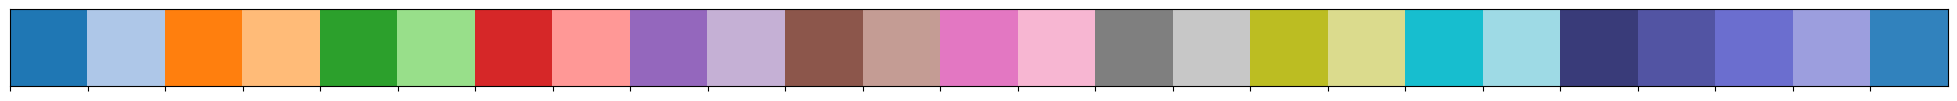

In [21]:
cmap1 = plt.get_cmap("tab20")
cmap2 = plt.get_cmap("tab20b")
cmap3 = plt.get_cmap("tab20c")
colors1 = cmap1.colors
colors2 = cmap2.colors
colors3 = cmap3.colors
contrast_palette = sns.color_palette(list(colors1) + list(colors2[:4]) + list(colors3[:1]))
sns.palplot(contrast_palette)

733303543.py (2): The palette list has more values (25) than needed (14), which may not be intended.


<Axes: xlabel='embedding_x', ylabel='embedding_y'>

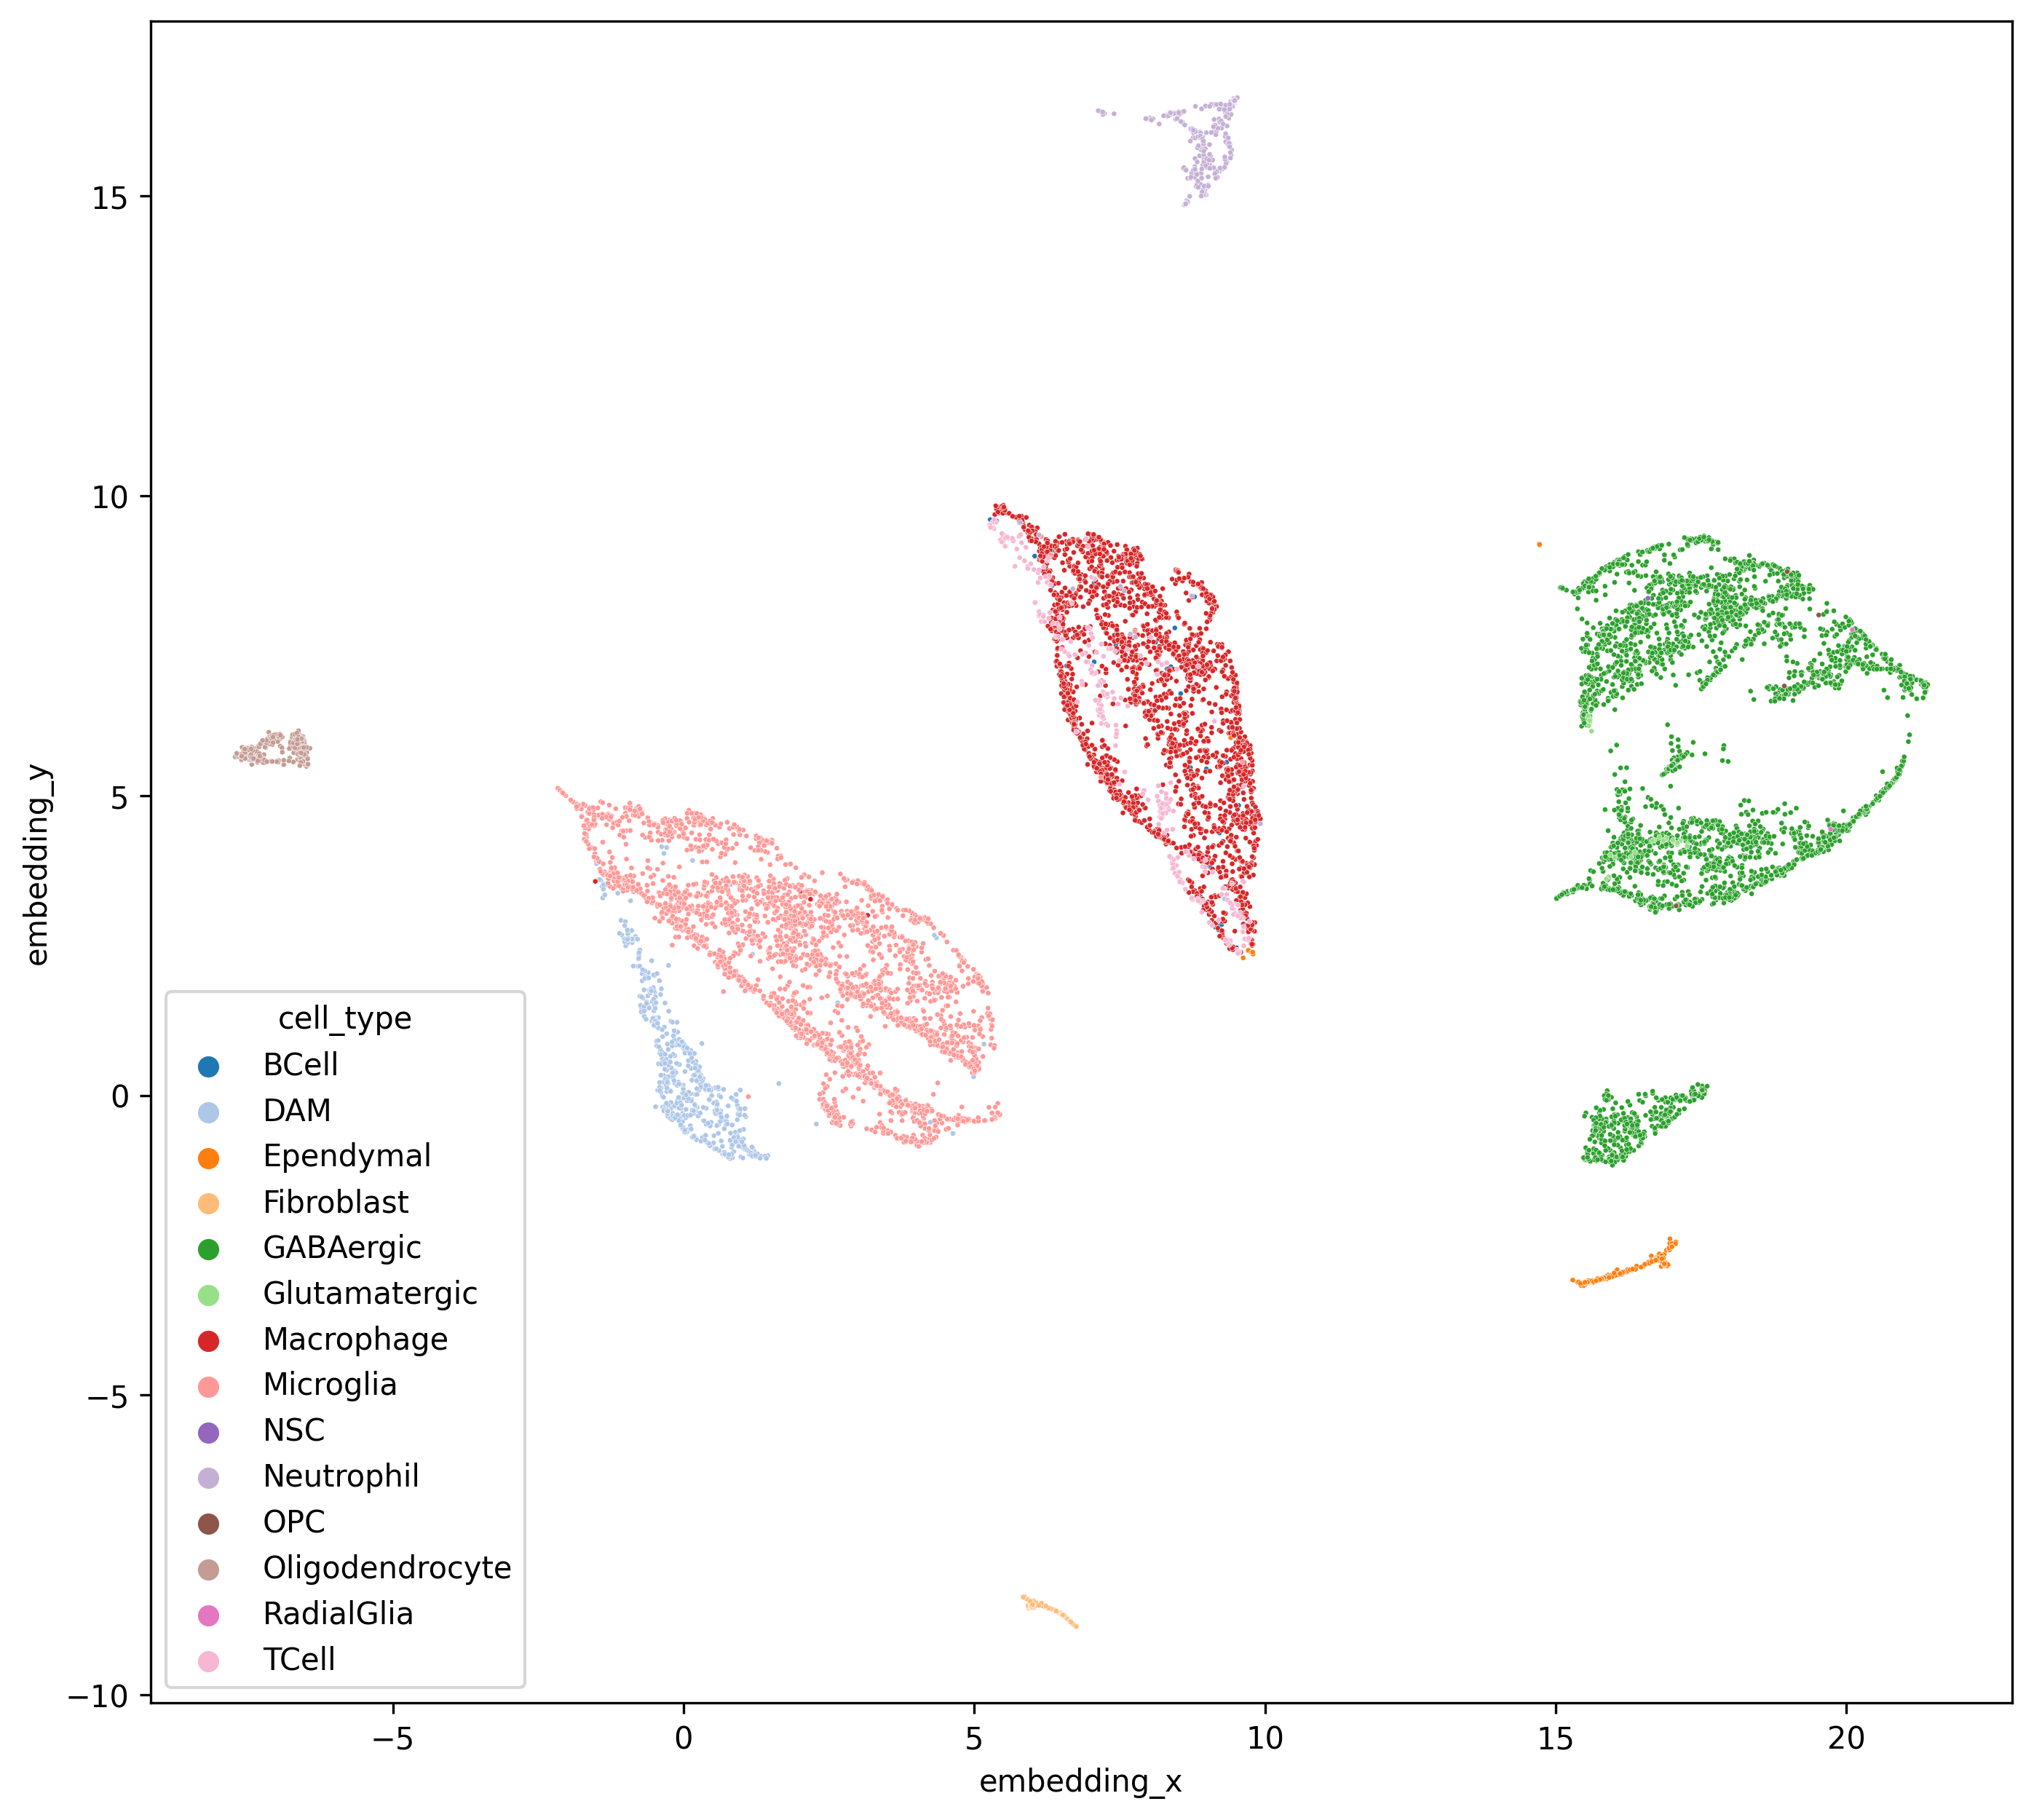

In [41]:
plt.figure(figsize=(11, 10), dpi=300)
sns.scatterplot(data = meta_df, x='embedding_x', y='embedding_y', s=3, hue='cell_type', palette=contrast_palette)
# plt.savefig(results_folder+'umap/umap1')

In [ ]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(np.log(X[meta_df['cell_type']=='Microglia']+1))
meta_df_micro = meta_df[meta_df['cell_type']=='Microglia']
meta_df_micro.loc[:, 'embedding_x'] = embedding[:, 0]
meta_df_micro.log[:, 'embedding_y'] = embedding[:, 1]

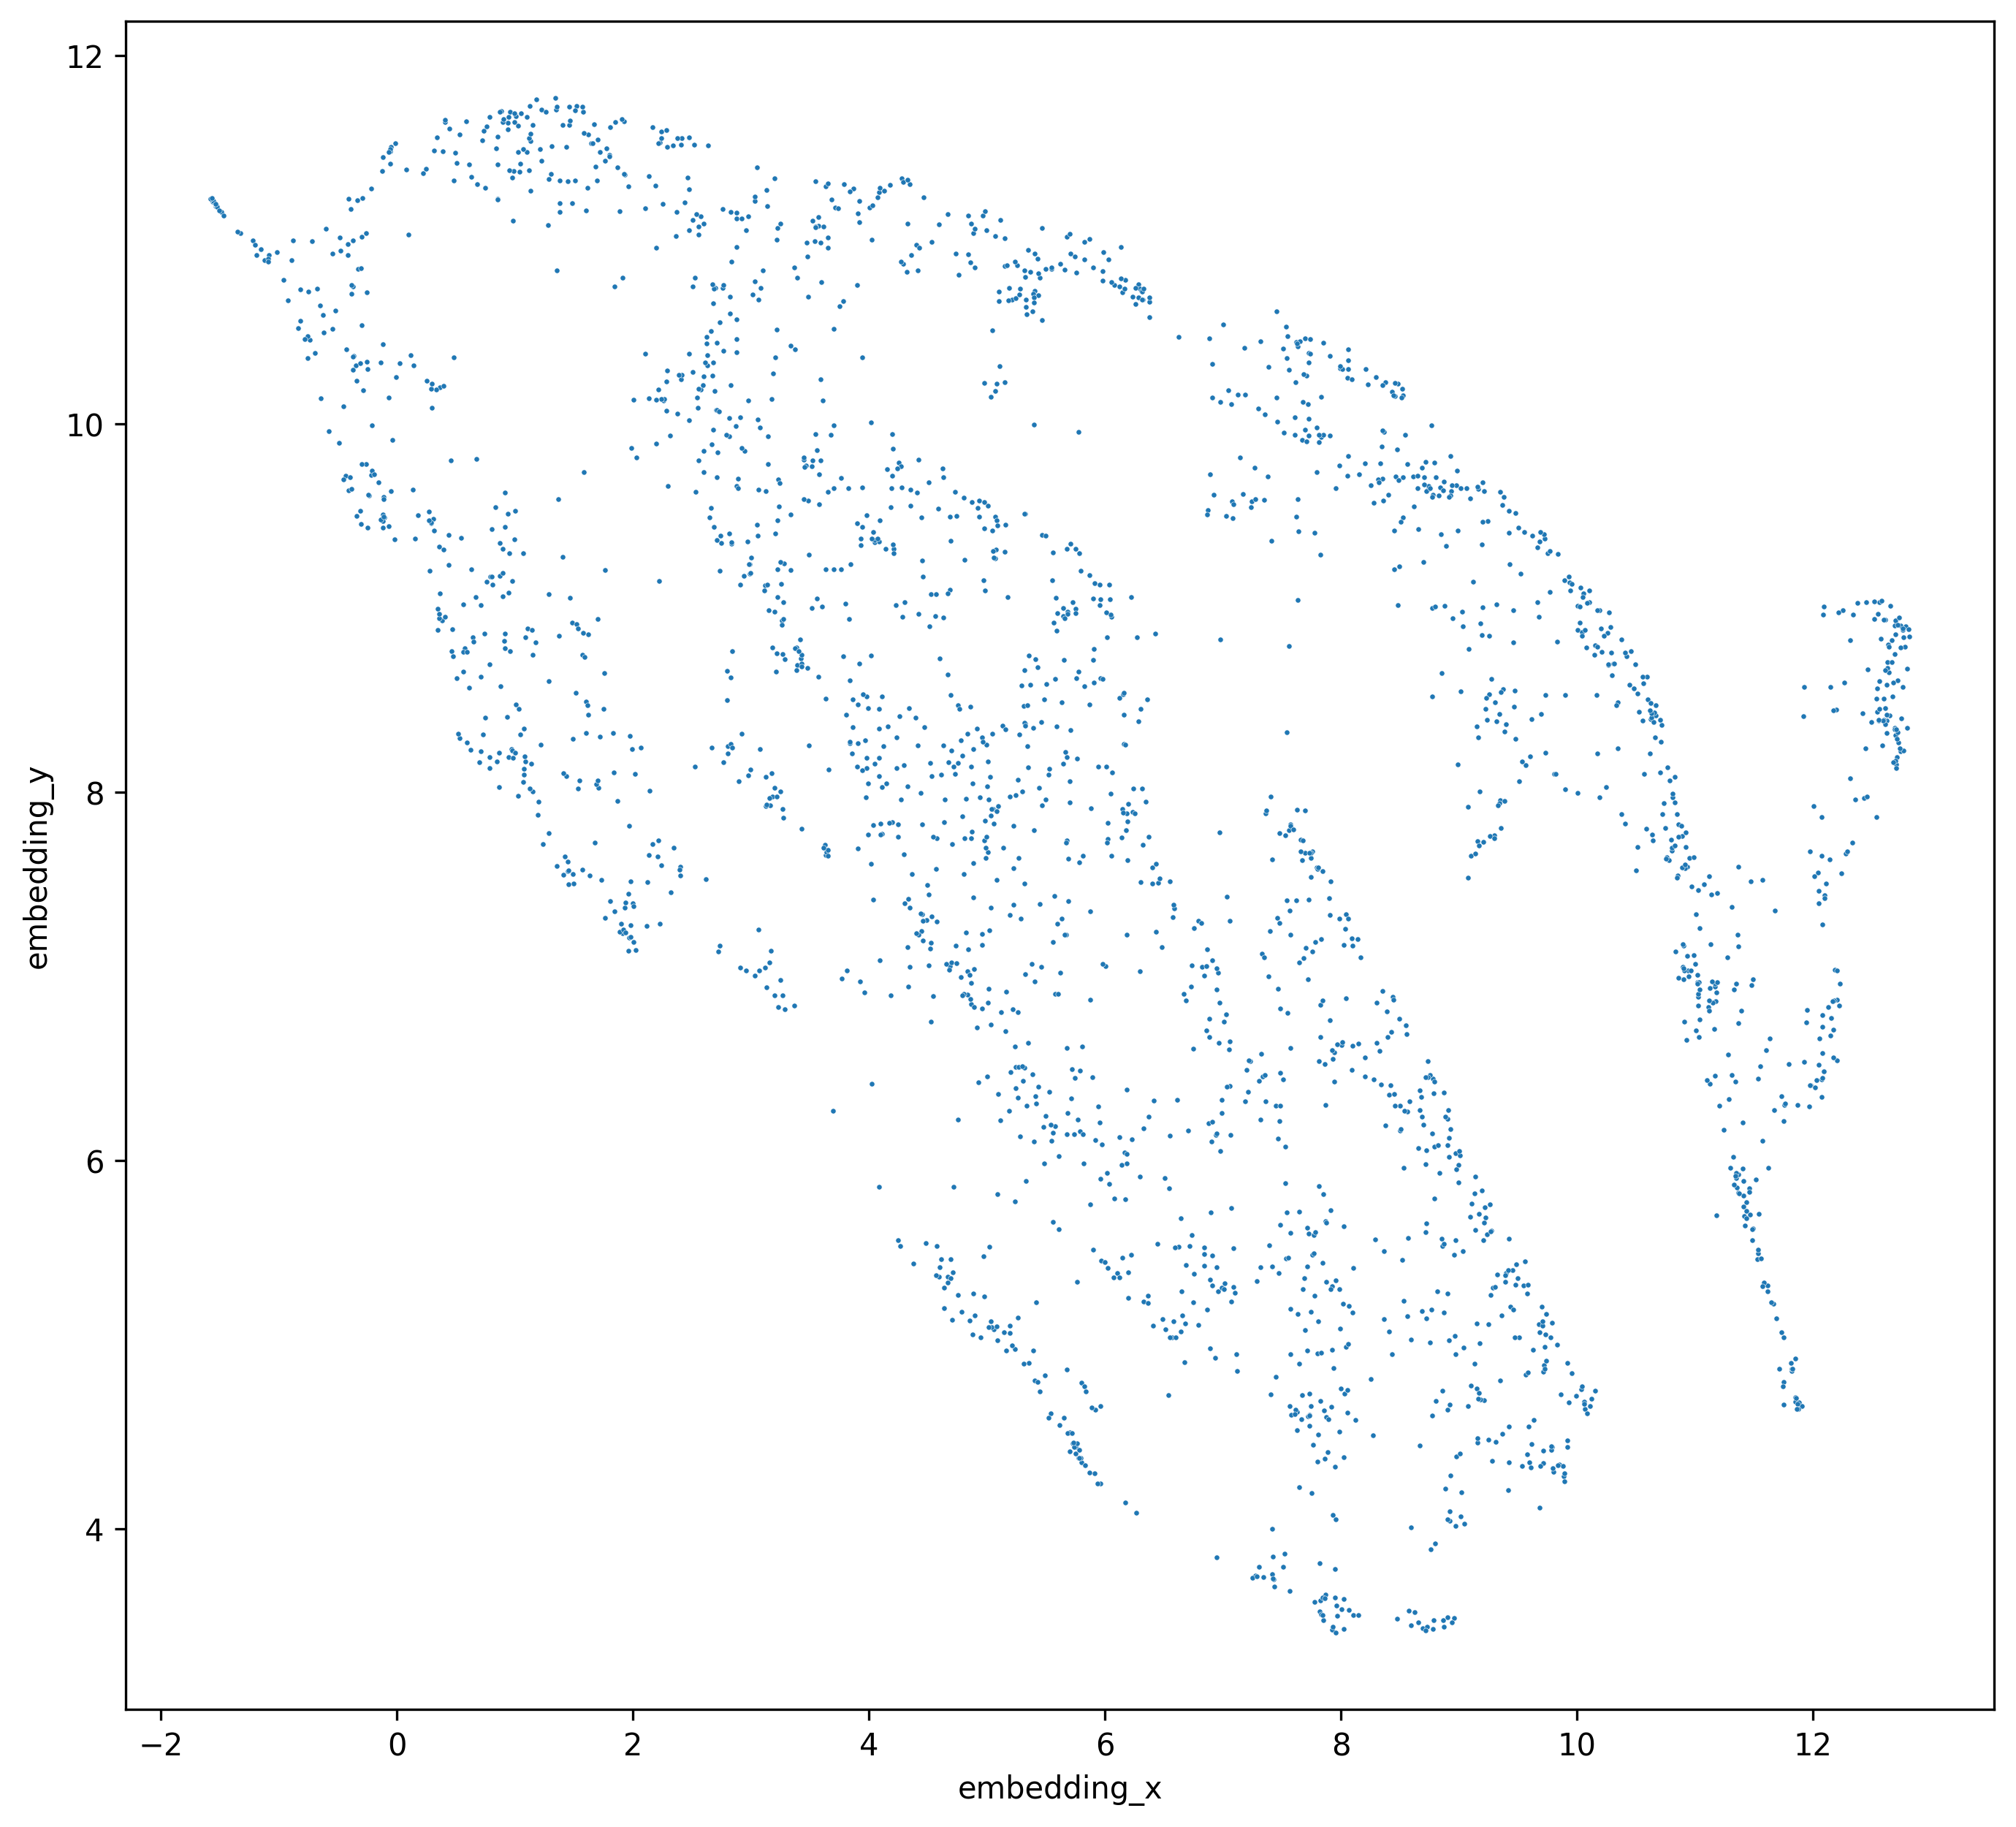

In [34]:
plt.figure(figsize=(11, 10), dpi=300)
sns.scatterplot(data = meta_df_micro, x='embedding_x', y='embedding_y', s=3)
plt.savefig(results_folder+'umap/umap_micro')

In [28]:
adata_st_decomposed_copy = adata_st_decomposed.copy()
sc.pp.normalize_per_cell(adata_st_decomposed_copy, counts_per_cell_after=1e4)
# sc.pp.log1p(adata_xe_copy)
adata_st_decomposed_copy.raw = adata_st_decomposed_copy
sc.pp.neighbors(adata_st_decomposed_copy, n_pcs = 30, n_neighbors = 20)
sc.tl.umap(adata_st_decomposed_copy)

         Falling back to preprocessing with `sc.pp.pca` and default params.


scatterplots.py (392): No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


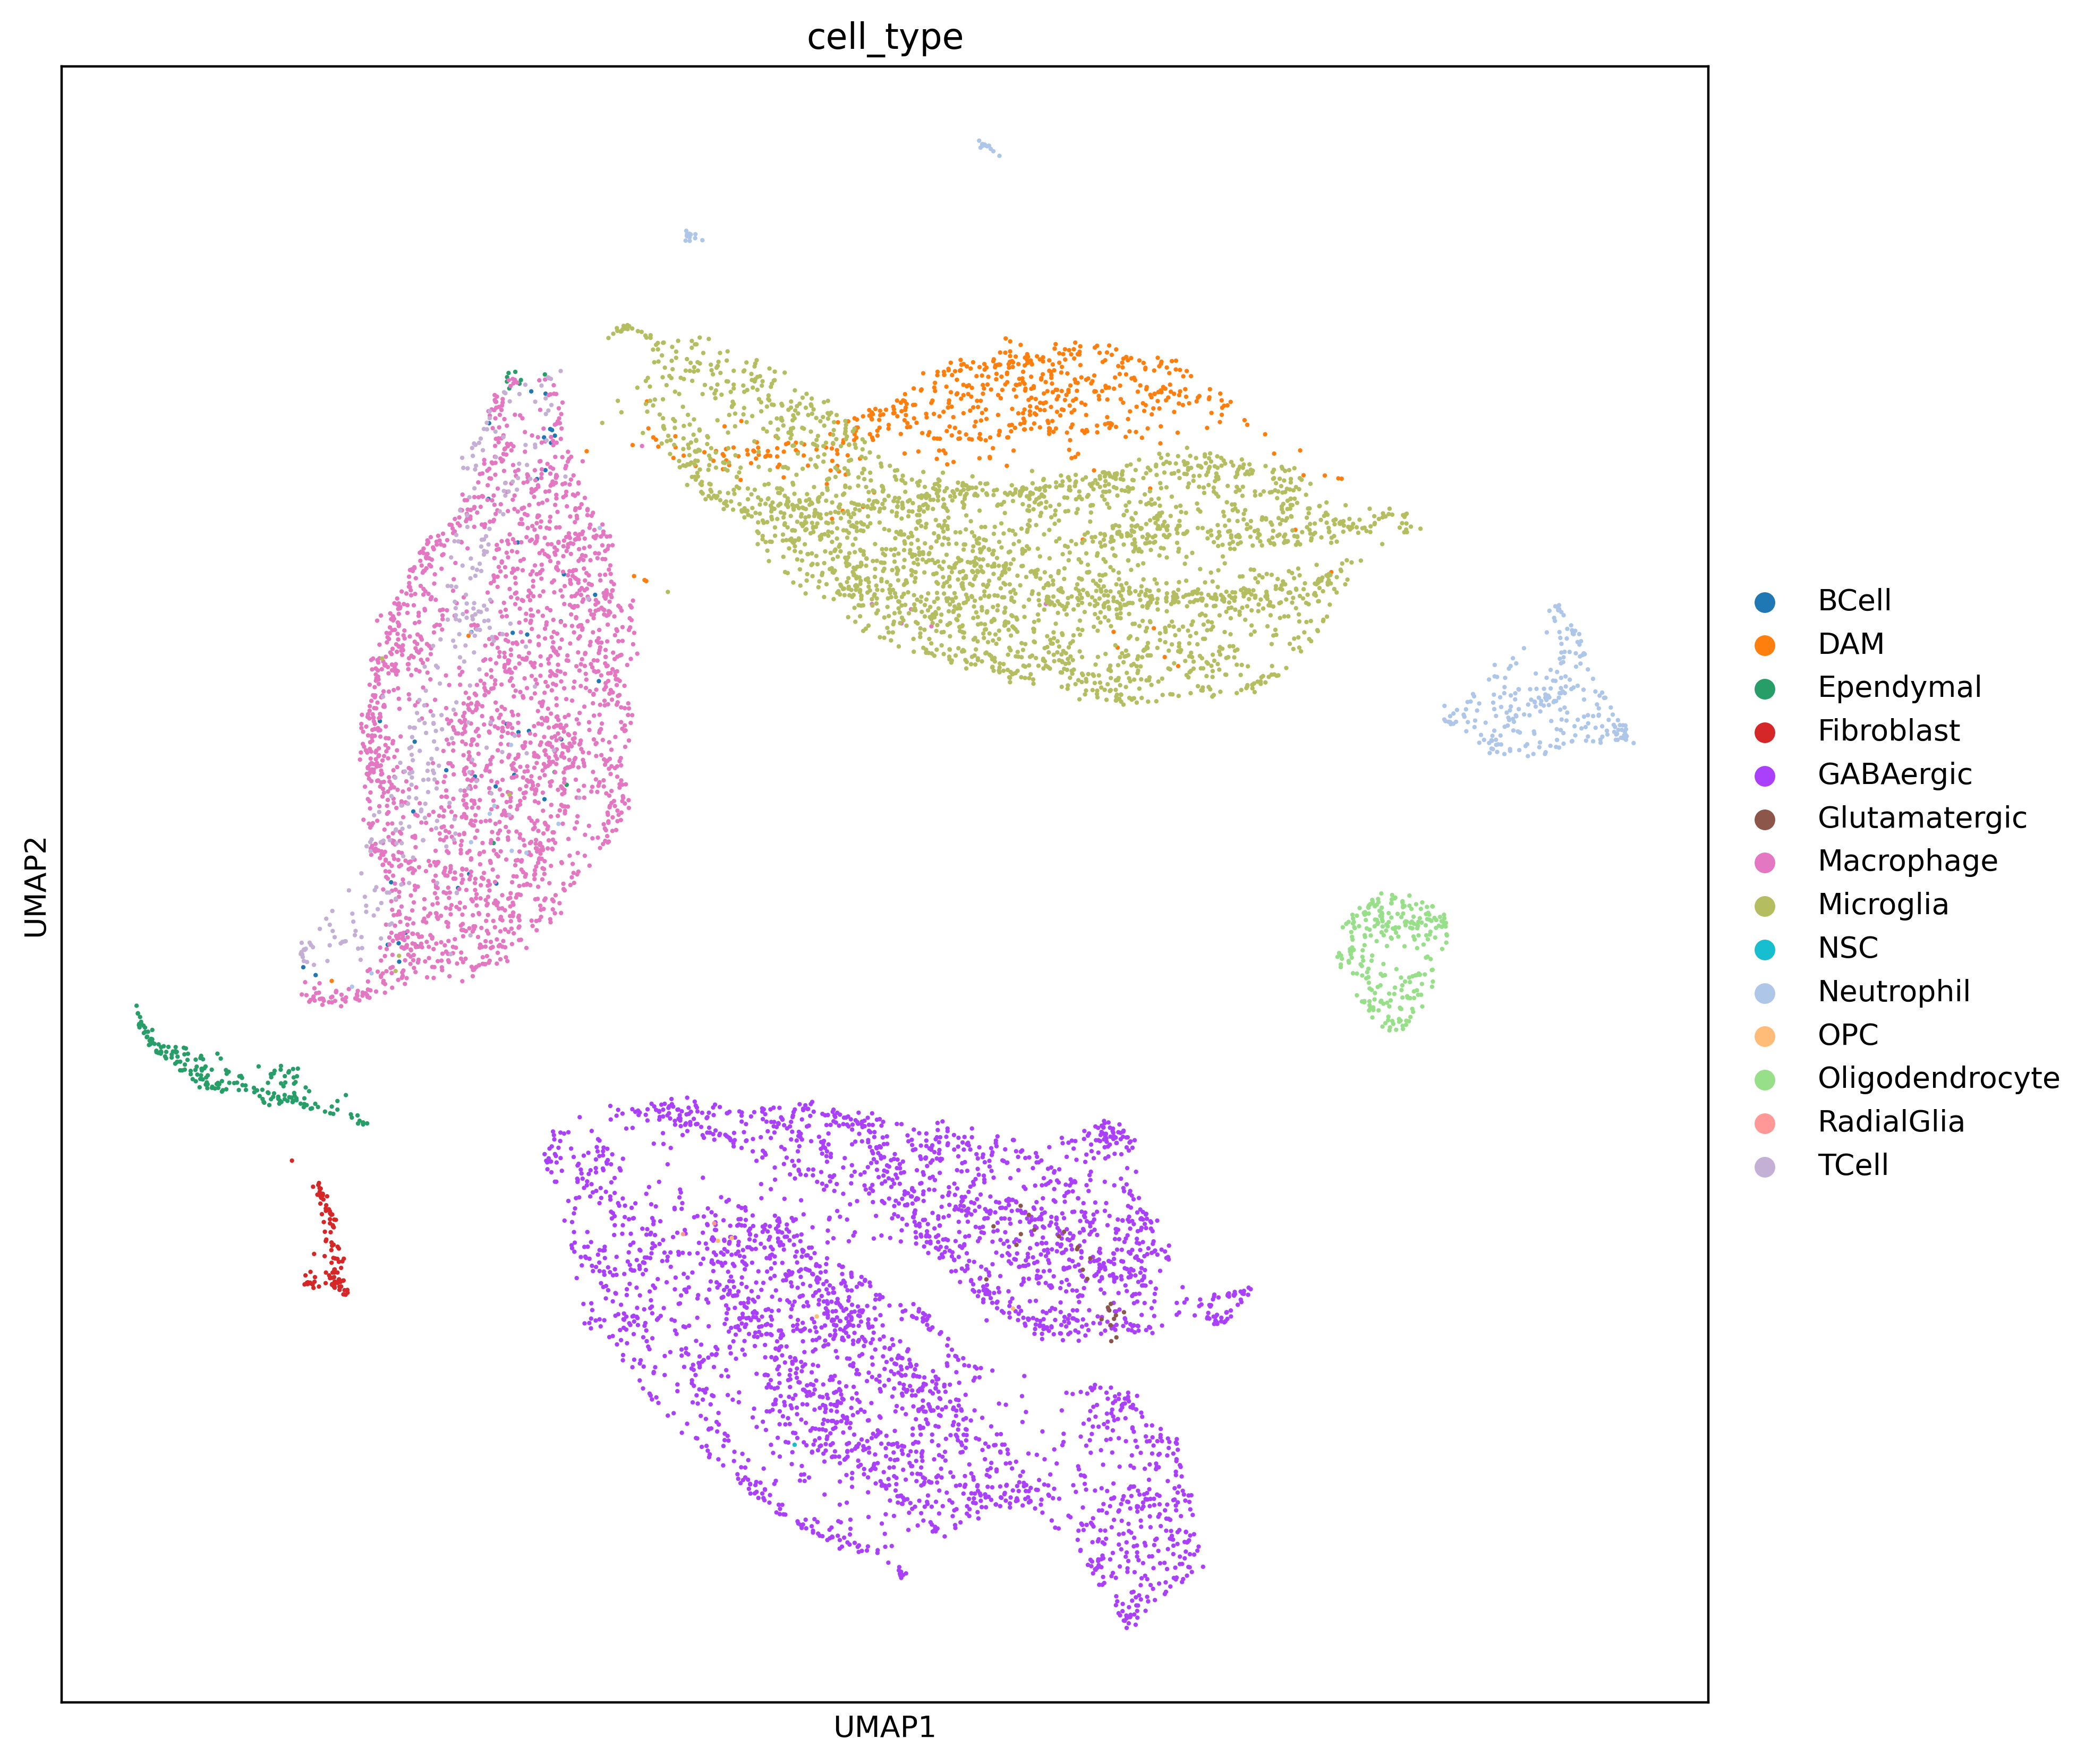

In [38]:
with mpl.rc_context({'figure.figsize': [10, 10], 'figure.dpi': 400}):
    ax = sc.pl.umap(adata_st_decomposed_copy, color='cell_type', size=9, show=False)
    ax.get_figure().savefig(results_folder+'umap/umap_scanpy')

3382992258.py (8): Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.


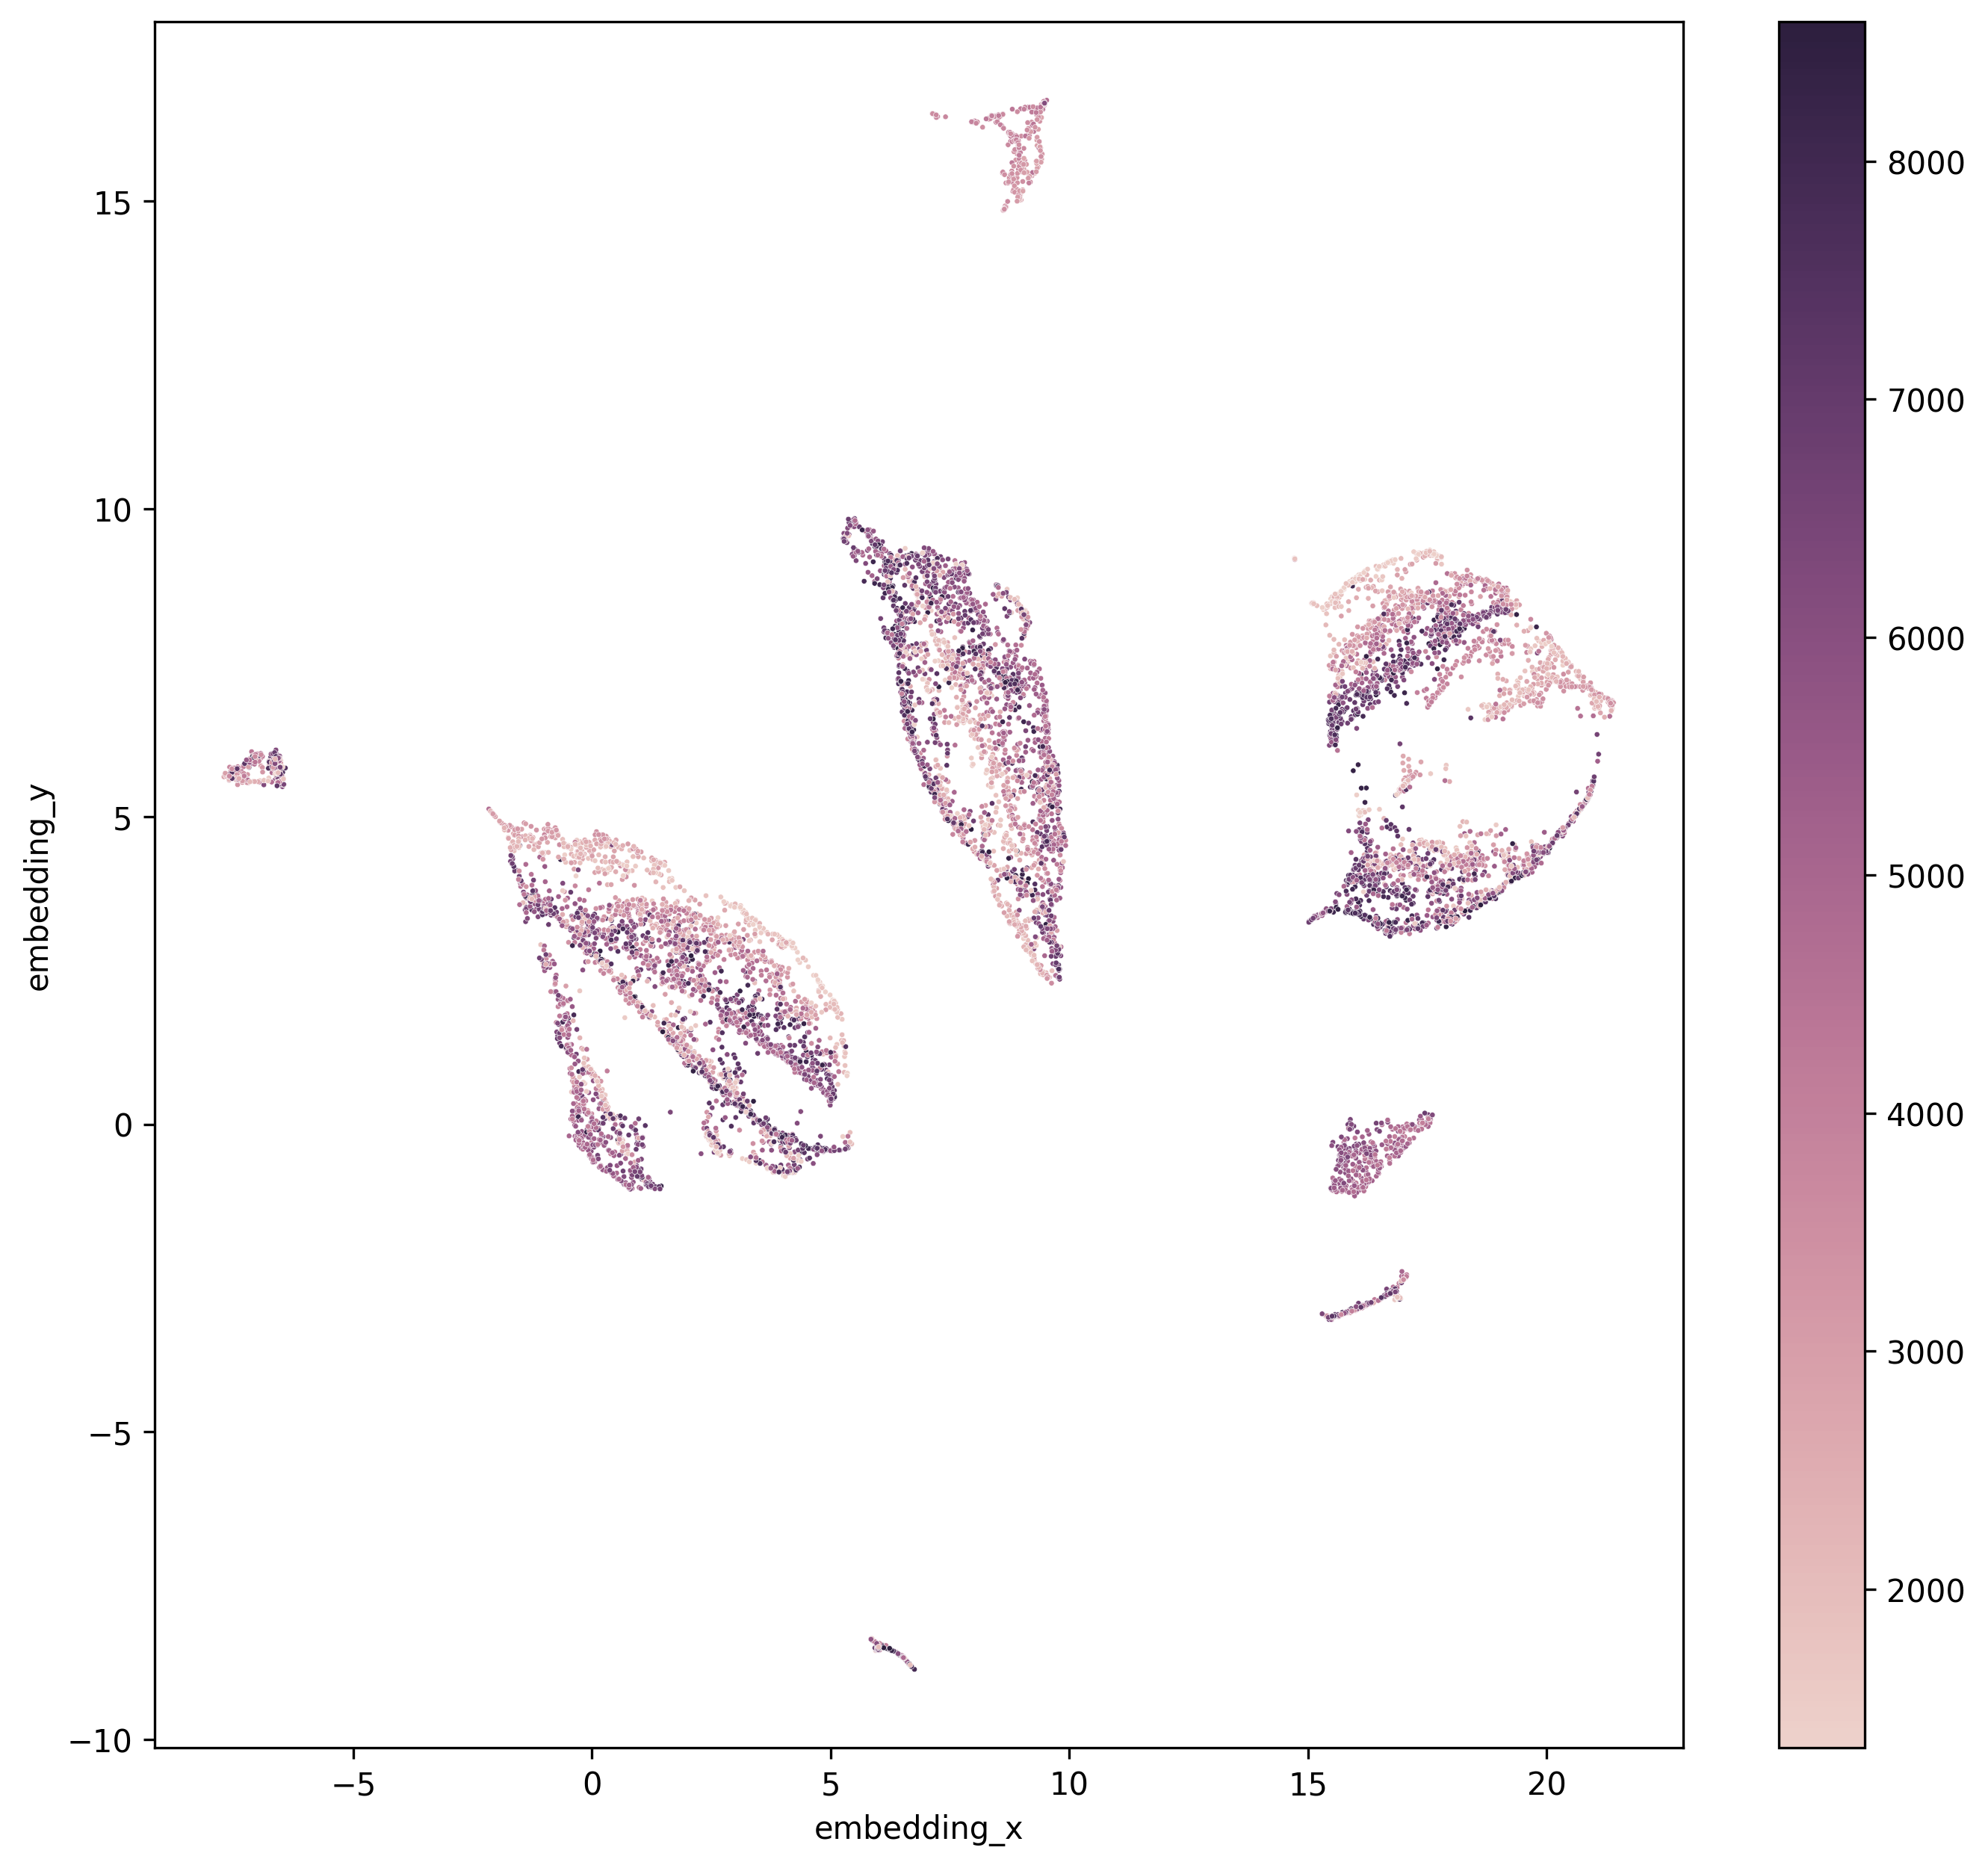

In [47]:
plt.figure(figsize=(11, 10), dpi=300)
cmap = sns.cubehelix_palette(as_cmap=True)
sns.scatterplot(data = meta_df, x='embedding_x', y='embedding_y', s=3, hue='location_y', palette=cmap, legend=False)

norm = plt.Normalize(meta_df['location_y'].min(), meta_df['location_y'].max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm)
plt.savefig(results_folder+'umap/umap_y')